# Εργασία Αριθμητικής Ανάλυσης

Χατζηγρίβας Κωνσταντίνος 10552
Λιούτας Γιώργος          10974

## Συλλογή Δεδομένων

In [ ]:
import yfinance as yfin

stock = yfin.Ticker("GOOG")
history = stock.history(start = "2025-04-28", end = "2025-05-03", interval="30m")
history['Open'].to_csv('open_prices.csv', header=True)

print(history['Open'].head())

Datetime
2025-05-12 09:30:00-04:00    159.000000
2025-05-12 10:00:00-04:00    158.634995
2025-05-12 10:30:00-04:00    158.600006
2025-05-12 11:00:00-04:00    158.649994
2025-05-12 11:30:00-04:00    158.330002
Name: Open, dtype: float64


## Πολυωνυμική Προσαρμογή Ελαχίστων Τετραγώνων

In [81]:
import numpy as np

def get_poly(x, y, degree):
	coeffs = np.polyfit(x, y, degree)
	poly = np.poly1d(coeffs)
	return poly

data = history['Open'].values
data_x = np.arange(len(data))

split_index = int(len(data_x) * 0.8)
data_x_train = data_x[:split_index]
data_x_test = data_x[split_index:]
data_train = data[:split_index]
data_test = data[split_index:]

poly1=get_poly(data_x_train, data_train, 1)
poly2=get_poly(data_x_train, data_train, 2)
poly3=get_poly(data_x_train, data_train, 3)

MAE1=0.0
MAE2=0.0
MAE3=0.0
MSE1=0.0
MSE2 =0.0
MSE3=0.0

for i in range(0, len(data_x_test)):
	MAE1 += np.abs(poly1(data_x_test[i]) - data_test[i])
	MAE2 += np.abs(poly2(data_x_test[i]) - data_test[i])
	MAE3 += np.abs(poly3(data_x_test[i]) - data_test[i])
	MSE1 += (poly1(data_x_test[i]) - data_test[i])**2
	MSE2 += (poly2(data_x_test[i]) - data_test[i])**2
	MSE3 += (poly3(data_x_test[i]) - data_test[i])**2

MAE1 /= len(data_test)
MAE2 /= len(data_test)
MAE3 /= len(data_test)
MSE1 /= len(data_test)
MSE2 /= len(data_test)
MSE3 /= len(data_test)

print(f"1ou bathmou: MAE:{MAE1:.4f}, MSE:{MSE1:.4f}")
print(f"2ou bathmou: MAE:{MAE2:.4f}, MSE:{MSE2:.4f}")
print(f"3ou bathmou: MAE:{MAE3:.4f}, MSE:{MSE3:.4f}")


1ou bathmou: MAE:1.5640, MSE:2.9300
2ou bathmou: MAE:0.8173, MSE:1.2102
3ou bathmou: MAE:9.0415, MSE:92.8872


Άρα το καλύτερο μοντέλο είναι αυτό του χ βαθμού, και αυτό θα χρησιμοποιούμε από εδώ και πέρα.

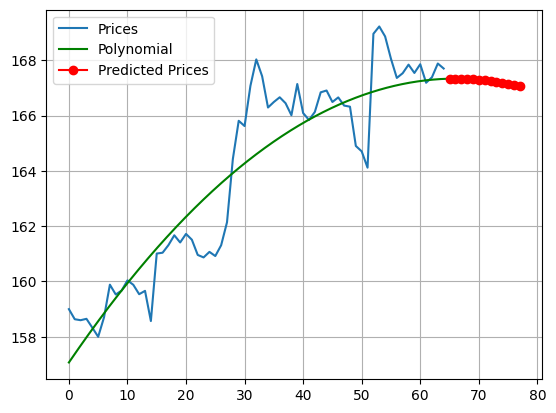

In [82]:
import matplotlib.pyplot as plot

x_pred = np.arange(len(data_x), len(data_x) + 13)
x_new = np.linspace(0, len(data_x) + 13 - 1, 1000)

if MAE1 <= MAE2 and MAE1 <= MAE3:
	y_pred = poly1(x_pred)
	y_new = poly1(x_new)
elif MAE2 <= MAE3 and MAE2 <= MAE1:
	y_pred = poly2(x_pred)
	y_new = poly2(x_new)
else:
	y_pred = poly3(x_pred)
	y_new = poly3(x_new)

plot.plot(data_x, data, label="Prices")
plot.plot(x_new, y_new, label="Polynomial", color='green')
plot.plot(x_pred, y_pred, label="Predicted Prices", color='red', marker='o')
plot.legend()
plot.grid(True)
plot.show()

In [83]:
def trap_area(y, h = 1):
	area = 0
	for i in range(len(y) - 1):
		area += (y[i] + y[i + 1]) * h / 2
	return area

def simp_area(y):
	n = len(y)

	s = y[0] + y[n - 1]

	for i in range(1, n - 1):
		if i % 2 == 0:
			s += 2 * y[i]
		else:
			s += 4 * y[i]

	area = (1 / 3) * s
	return area

def get_area(poly, step, start, stop):
	x = np.linspace(start, stop, step)
	y = poly(x)
	h = (stop - start) / (step - 1)
	a = trap_area(y, h)
	a /= (stop - start)
	return a

a_simp = simp_area(data)
a_trap = trap_area(data)
m_simp = a_simp / len(data)
m_trap = a_trap / len(data)

print(f"Trapezoid: Area:{a_trap} Mean:{m_trap}")
print(f"Simpson: Area:{a_simp} Mean:{m_simp}")
print()
print(f"Degree 1 Area:{get_area(poly1, 100, 0, len(data))}")
print(f"Degree 2 Area:{get_area(poly2, 100, 0, len(data))}")
print(f"Degree 3 Area:{get_area(poly3, 100, 0, len(data))}")

Trapezoid: Area:10492.421257019043 Mean:161.42186549260066
Simpson: Area:10492.205022176106 Mean:161.41853880270932

Degree 1 Area:164.26588679740055
Degree 2 Area:163.85336110761466
Degree 3 Area:162.06058405332536


In [84]:
def aitken(x, y, val):
	arr = [[0 for _ in range(len(x))] for _ in range(len(x))]

	for i in range(len(x)):
		arr[i][0] = y[i]
	
	for j in range(1, len(x)):
		for i in range(j, len(x)):
			arr[i][j] = ((x[j - 1] - val) * arr[i][j - 1] - (x[i] - val) * arr[j - 1][j - 1]) / (x[j - 1] - x[i])
	
	return arr[len(x) - 1][len(x) - 1]

def n_divided(x, y, val):
	arr = [[0 for _ in range(len(x))] for _ in range(len(x))]

	for i in range(len(x)):
		arr[i][0] = y[i]

	for j in range(1, len(x)):
		for i in range(len(x) - j):
			arr[i][j] = (arr[i+1][j-1]-arr[i][j-1]) / (x[i+j]-x[i])
	
	coef = []
	for i in range(len(x)):
		coef.append(arr[0][i])

	r = coef[0]
	p = 1.0
	for i in range(1, len(coef)):
		p *= (val - x[i - 1])
		r += coef[i] * p
	return r

print("Prediction Values:")
for i in range(0, len(data_x) - 5, 5):
	new_x = data_x[i:i + 5]
	new_y = data[i:i + 5]
	x_targ = data_x[i + 5]
	y_targ = data[i + 5]
	aitken_res = aitken(new_x, new_y, x_targ)
	newton = n_divided(new_x, new_y, x_targ)

	print(f"x:{x_targ:2d}, y:{y_targ:.2f} -> Aitken:{aitken_res:.2f} Netwon:{newton:.2f} Aitken diff:{np.abs(aitken_res - y_targ):5.2f} Newton diff:{np.abs(newton - y_targ):5.2f}")

Prediction Values:
x: 5, y:158.00 -> Aitken:156.98 Netwon:156.98 Aitken diff: 1.02 Newton diff: 1.02
x:10, y:160.04 -> Aitken:166.37 Netwon:166.37 Aitken diff: 6.33 Newton diff: 6.33
x:15, y:161.01 -> Aitken:152.28 Netwon:152.28 Aitken diff: 8.73 Newton diff: 8.73
x:20, y:161.72 -> Aitken:159.31 Netwon:159.31 Aitken diff: 2.41 Newton diff: 2.41
x:25, y:160.92 -> Aitken:160.42 Netwon:160.42 Aitken diff: 0.50 Newton diff: 0.50
x:30, y:165.62 -> Aitken:160.52 Netwon:160.52 Aitken diff: 5.10 Newton diff: 5.10
x:35, y:166.49 -> Aitken:167.79 Netwon:167.79 Aitken diff: 1.30 Newton diff: 1.30
x:40, y:166.09 -> Aitken:173.25 Netwon:173.25 Aitken diff: 7.16 Newton diff: 7.16
x:45, y:166.49 -> Aitken:164.32 Netwon:164.32 Aitken diff: 2.17 Newton diff: 2.17
x:50, y:164.71 -> Aitken:158.11 Netwon:158.11 Aitken diff: 6.59 Newton diff: 6.59
x:55, y:168.05 -> Aitken:185.78 Netwon:185.78 Aitken diff:17.73 Newton diff:17.73
x:60, y:167.85 -> Aitken:165.85 Netwon:165.85 Aitken diff: 2.01 Newton diff: 2.